### Imports

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import metrics
import math
from random import sample
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from funcsigs import signature
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.layers import MaxPool2D, Dropout
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import RMSprop

### Load dataset

In [37]:
data = np.load("input/olivetti_faces.npy")
target = np.load("input/olivetti_faces_target.npy")

### Dataset information

In [38]:
print("Dataset information")
print(f"Number of images: {data.shape[0]}")  # 400
print(f"Number of unique targets: {len(np.unique(target))}")  # 40
print(f"Image size: {data.shape[1]}x{data.shape[2]}px")  # 64x64
print(f"Pixel color values normalized to [0, 1]. Example: {data[0][0, :4]}")

Dataset information
Number of images: 400
Number of unique targets: 40
Image size: 64x64px
Pixel color values normalized to [0, 1]. Example: [0.30991736 0.3677686  0.41735536 0.44214877]


### Data visualization

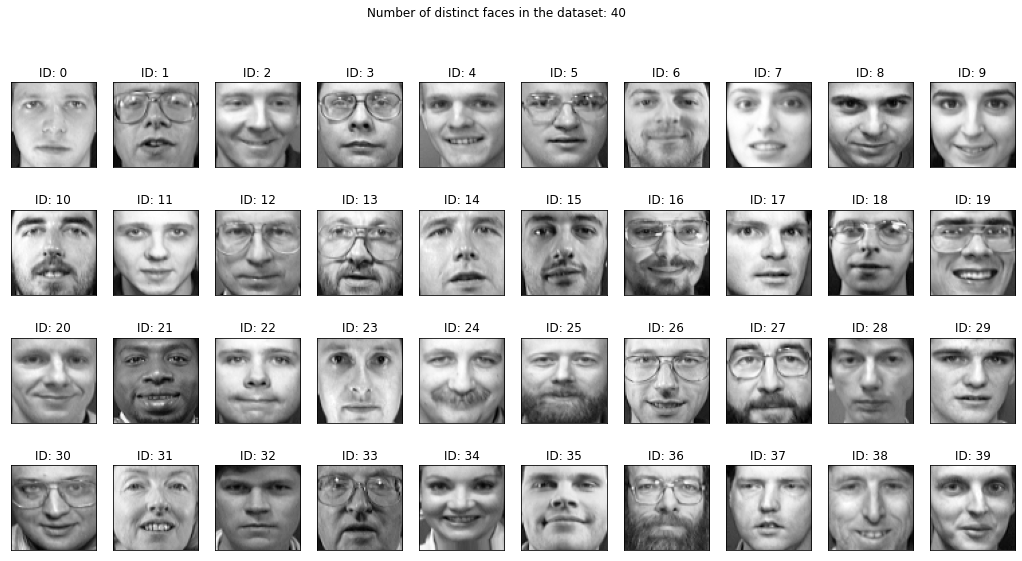

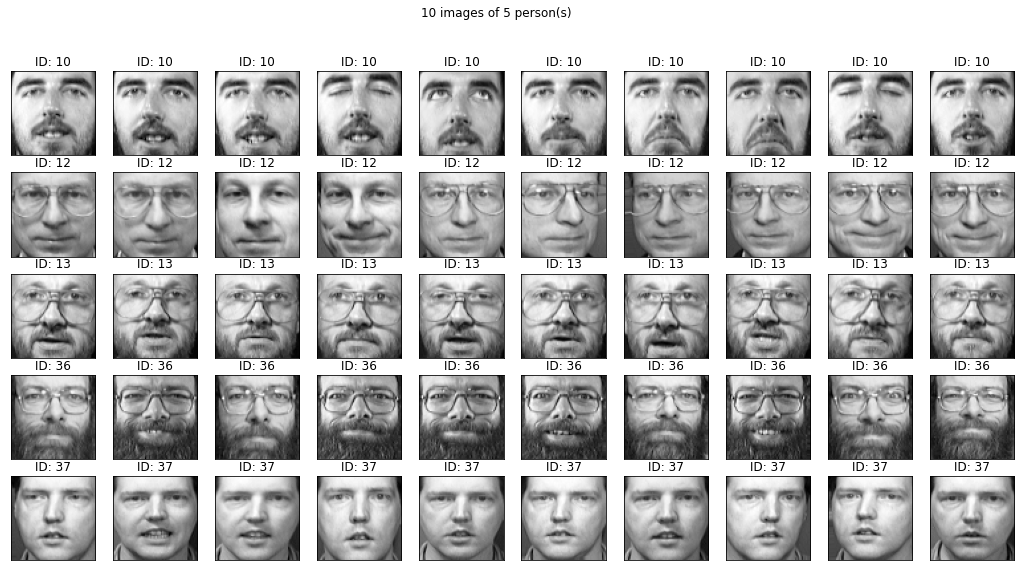

In [39]:
def plot_distinct_faces(data, target, ncols=10, figsize=(18, 9)):
    unique_ids = np.unique(target)
    n_unique = len(unique_ids)
    nrows = math.ceil(n_unique / ncols)
    fig, axarr = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axarr = axarr.flatten()

    for unique_id in unique_ids:
        image_index = unique_id * 10
        axarr[unique_id].imshow(data[image_index], cmap="gray")
        axarr[unique_id].set_xticks([])
        axarr[unique_id].set_yticks([])
        axarr[unique_id].set_title(f"ID: {unique_id}")
    plt.suptitle(f"Number of distinct faces in the dataset: {n_unique}")


def plot_faces_of_subjects(data, subj_ids, ncols=10, figsize=(18, 9), imgs_per_subj=10):
    nrows = math.ceil(len(subj_ids) * imgs_per_subj / ncols)
    fig, axarr = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

    for i, subj_id in enumerate(subj_ids):
        for j in range(ncols):
            img_idx = subj_id * ncols + j
            axarr[i, j].imshow(data[img_idx], cmap="gray")
            axarr[i, j].set_xticks([])
            axarr[i, j].set_yticks([])
            axarr[i, j].set_title(f"ID: {subj_id}")
    plt.suptitle(f"{imgs_per_subj} images of {len(subj_ids)} person(s)")


plot_distinct_faces(data, target)

unique_ids = np.unique(target).tolist()
n_subjs = min(len(unique_ids), 5)  # Arbitrary, for exemplification purposes
rand_subj_ids = sorted(sample(unique_ids, n_subjs))
plot_faces_of_subjects(data, rand_subj_ids)

### Preprocessing

In [40]:
# Reshape images (matrix to vector)
X = data.reshape((data.shape[0], data.shape[1] * data.shape[2]))
print(f"{X.shape = }")

X.shape = (400, 4096)


### Split data and target into train and test subsets

In [41]:
# stratify makes an equal number of train and test images for each subject
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.3, stratify=target, random_state=0)
print(f"{X_train.shape = }")
print(f"{y_train.shape = }")

X_train.shape = (280, 4096)
y_train.shape = (280,)


<AxesSubplot:title={'center':'Number of Samples for Each Classes'}, xlabel='subject ids'>

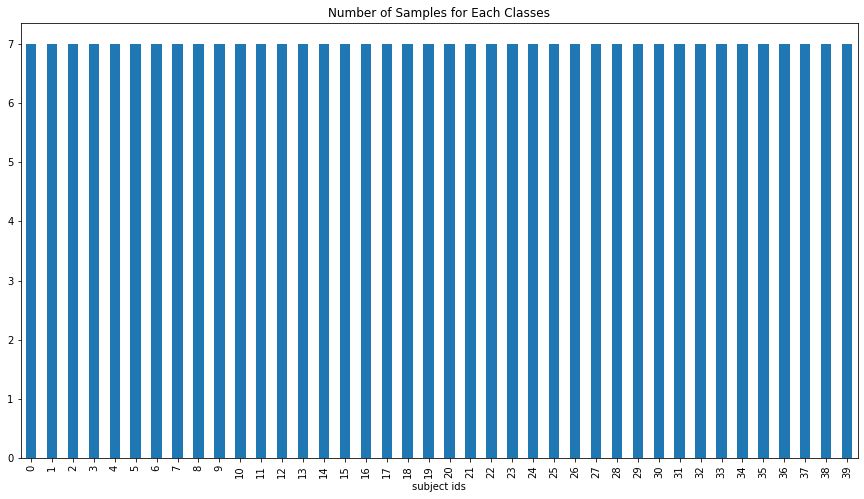

In [42]:
# Verify that each subject has 7 training images
y_frame = pd.DataFrame()
y_frame['subject ids'] = y_train
y_frame.groupby(['subject ids']).size().plot.bar(figsize=(15, 8), title="Number of Samples for Each Classes")

### Unsupervised learning: Principal Component Analysis

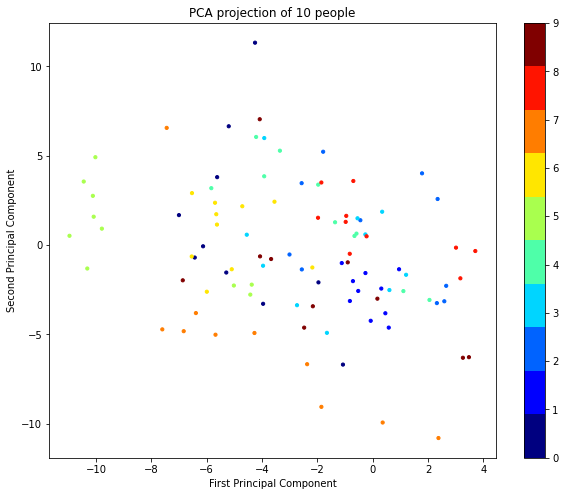

In [43]:
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

number_of_people = 10
index_range = number_of_people * 10
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1)
scatter = ax.scatter(X_pca[:index_range, 0],
                     X_pca[:index_range, 1],
                     c=target[:index_range],
                     s=10,
                     cmap=plt.get_cmap("jet", number_of_people)
                     )

ax.set_xlabel("First Principal Component")
ax.set_ylabel("Second Principal Component")
ax.set_title(f"PCA projection of {number_of_people} people")

fig.colorbar(scatter)

PCA: Optimizing number of components

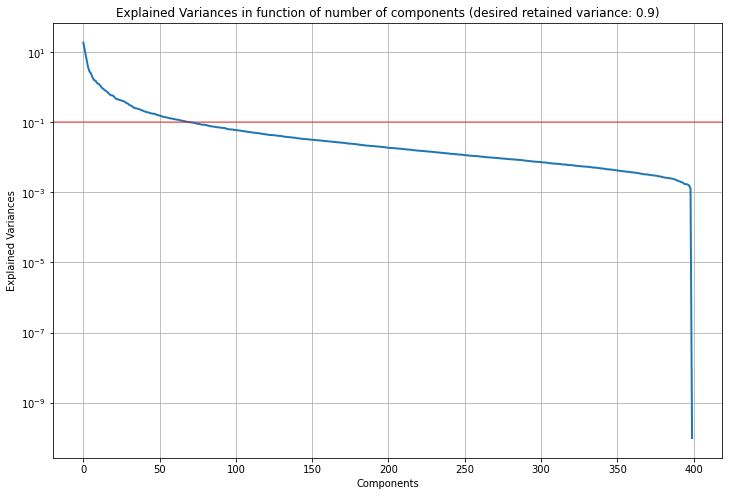

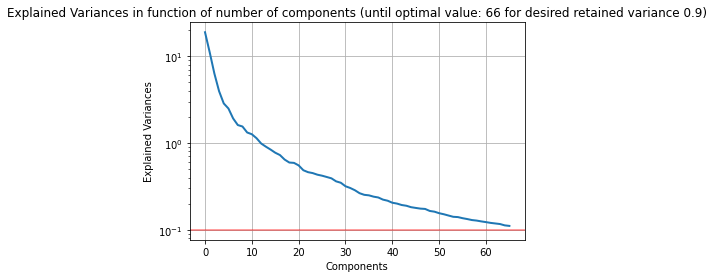

Optimal number of components: 66


In [44]:
desired_retained_var = .9

pca = PCA()  # All components
pca.fit(X)

plt.figure(1, figsize=(12, 8))

plt.plot(pca.explained_variance_, linewidth=2)
plt.axhline(y=1 - desired_retained_var, color="r", alpha=.5)
plt.yscale("log")
plt.xlabel("Components")
plt.ylabel("Explained Variances")
plt.title(
    f"Explained Variances in function of number of components (desired retained variance: {desired_retained_var})")
plt.grid()
plt.show()

# sklearn: select the number of components such that the amount of variance that needs to be explained is greater than the percentage specified by n_components.
pca = PCA(n_components=desired_retained_var)
pca.fit(X)
k = pca.n_components_

plt.plot(pca.explained_variance_, linewidth=2)
plt.axhline(y=1 - desired_retained_var, color="r", alpha=.5)
plt.yscale("log")
plt.xlabel("Components")
plt.ylabel("Explained Variances")
plt.title(
    f"Explained Variances in function of number of components (until optimal value: {k} for desired retained variance {desired_retained_var})")
plt.grid()
plt.show()

print(f"Optimal number of components: {k}")

### Apply PCA with optimal number of components

PCA Whitening is a dimensionality reduction algorithm and processing step for image based data that makes input less redundant. Adjacent pixel or feature values can be highly correlated, and whitening through the use of PCA reduces this degree of correlation.
It can be used to significantly speed up unsupervised feature learning algorithms.


In [45]:
pca = PCA(n_components=k, whiten=True)
pca.fit(X_train)
pass

### Average Face

Text(0.5, 1.0, 'Average Face')

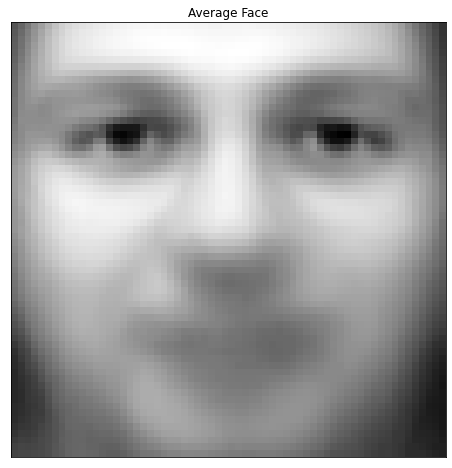

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(pca.mean_.reshape((64, 64)), cmap="gray")
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Average Face")

### Eigenfaces

Text(0.5, 0.98, 'Eigen Faces')

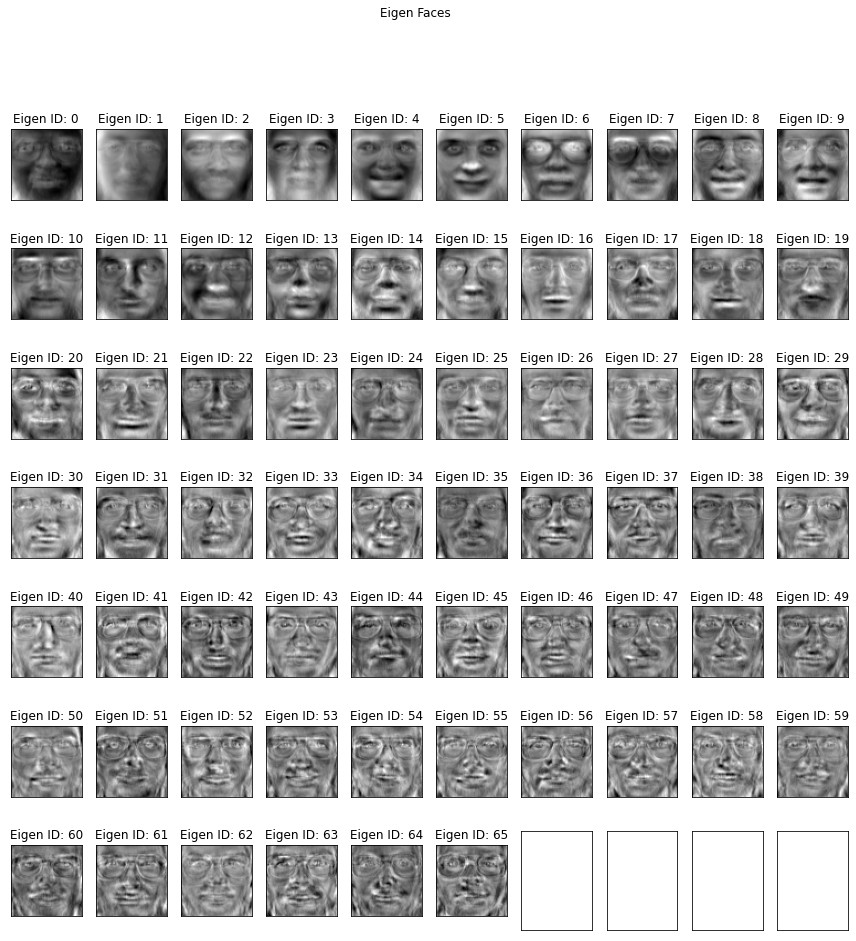

In [47]:
number_of_eigenfaces = len(pca.components_)
eigenfaces = pca.components_.reshape((number_of_eigenfaces, data.shape[1], data.shape[2]))

ncols = 10
nrows = math.ceil(number_of_eigenfaces / ncols)
fig, axarr = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))
axarr = axarr.flatten()
for i, eigenface in enumerate(eigenfaces):
    axarr[i].imshow(eigenface, cmap="gray")
    axarr[i].set_xticks([])
    axarr[i].set_yticks([])
    axarr[i].set_title(f"Eigen ID: {i}")
for i in range(number_of_eigenfaces, nrows * ncols):
    axarr[i].set_xticks([])
    axarr[i].set_yticks([])
plt.suptitle("Eigen Faces")

### Application of ML models

In [60]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

models = [
    ("LDA", LinearDiscriminantAnalysis()),
    ("LR", LogisticRegression()),
    ("NB", GaussianNB()),
    ("KNN", KNeighborsClassifier(n_neighbors=5)),
    ("DT", DecisionTreeClassifier()),
    ("SVM", SVC()),
]

print(int(100 * desired_retained_var))
print("Accuracy scores")
for name, model in models:
    clf = model
    clf.fit(X_train_pca, y_train)
    y_pred = clf.predict(X_test_pca)
    print(f"{name:3s}: {metrics.accuracy_score(y_test, y_pred):0.3f}")

pca = PCA(n_components=k, whiten=True)
pca.fit(X)
X_pca = pca.transform(X)
print("\nK-fold cross-validation scores")
for name, model in models:
    kfold = KFold(n_splits=10, shuffle=True, random_state=0)
    cv_scores = cross_val_score(model, X_pca, target, cv=kfold)
    print(f"{name:3s}: {cv_scores.mean():.2f}")

print("\nLeave One Out cross-validation scores")
for name, model in models:
    cv = LeaveOneOut()
    cv_scores = cross_val_score(model, X_pca, target, cv=cv)
    print(f"{name:3s}: {cv_scores.mean():.2f}")



c:\users\tomec\ua\taa\taa_p2\venv\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


90
Accuracy scores
LDA: 0.942
LR : 0.925
NB : 0.908
KNN: 0.758
DT : 0.650
SVM: 0.925


ValueError: in user code:

    File "c:\users\tomec\ua\taa\taa_p2\venv\lib\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "c:\users\tomec\ua\taa\taa_p2\venv\lib\site-packages\keras\engine\training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\users\tomec\ua\taa\taa_p2\venv\lib\site-packages\keras\engine\training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "c:\users\tomec\ua\taa\taa_p2\venv\lib\site-packages\keras\engine\training.py", line 889, in train_step
        y_pred = self(x, training=True)
    File "c:\users\tomec\ua\taa\taa_p2\venv\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\users\tomec\ua\taa\taa_p2\venv\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_8" is incompatible with the layer: expected shape=(None, 64, 64, 1), found shape=(None, 66)


### Hyperparameter Tuning

In [ ]:
params = {'penalty': ['l1', 'l2'],
          'C': np.logspace(0, 4, 10)
          }
clf = LogisticRegression(solver="liblinear")
gridSearchCV = GridSearchCV(clf, params, cv=LeaveOneOut(), error_score="raise")
gridSearchCV.fit(X_train_pca, y_train)

print(f"{gridSearchCV.best_params_ = }")
print(f"{gridSearchCV.best_score_ = }")
print(f"grid search cross validation score: {gridSearchCV.score(X_test_pca, y_test):.2f}")

lda = LinearDiscriminantAnalysis()
params = {"solver": ['svd', 'lsqr', 'eigen']}
search = GridSearchCV(lda, params, cv=LeaveOneOut(), error_score="raise")
res = search.fit(X_train_pca, y_train)
print(f"{res.best_params_ = }")
print(f"{res.best_score_ = }")
print(f"grid search cross validation score: {search.score(X_test_pca, y_test):.2f}")


# tol: Absolute threshold for a singular value of X to be considered significant, used to estimate the rank of X. Dimensions whose singular values are non-significant are discarded. Only used if solver is ‘svd’.
lda = LinearDiscriminantAnalysis()
params = {"solver": ['svd'], "tol": [1e-4, 2e-4, 3e-4]}
search = GridSearchCV(lda, params, cv=LeaveOneOut(), error_score="raise")
res = search.fit(X_train_pca, y_train)
print(f"{res.best_params_ = }")
print(f"{res.best_score_ = }")
print(f"grid search cross validation score: {search.score(X_test_pca, y_test):.2f}")

### Confusion Matrix for LDA

In [ ]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_pca, y_train)
y_pred = lda.predict(X_test_pca)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
plt.subplots(1, figsize=(12, 12))
sns.heatmap(confusion_matrix)
plt.title("LDA Confusion Matrix")

### Precision-Recall-ROC Curves

In [ ]:

target = label_binarize(target, classes=range(40))
n_classes = target.shape[1]

X_train_multiclass, X_test_multiclass, y_train_multiclass, y_test_multiclass = train_test_split(
    X,
    target,
    test_size=0.3,
    stratify=target,
    random_state=0
)

pca = PCA(n_components=k, whiten=True)
pca.fit(X_train_multiclass)

X_train_multiclass_pca = pca.transform(X_train_multiclass)
X_test_multiclass_pca = pca.transform(X_test_multiclass)

lda = LinearDiscriminantAnalysis()

oneRestClassifier = OneVsRestClassifier(lda)

oneRestClassifier.fit(X_train_multiclass_pca, y_train_multiclass)
y_score = oneRestClassifier.decision_function(X_test_multiclass_pca)

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = metrics.precision_recall_curve(y_test_multiclass[:, i],
                                                                y_score[:, i])
    average_precision[i] = metrics.average_precision_score(y_test_multiclass[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = metrics.precision_recall_curve(y_test_multiclass.ravel(),
                                                                        y_score.ravel())
average_precision["micro"] = metrics.average_precision_score(y_test_multiclass, y_score,
                                                             average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.figure(1, figsize=(12, 8))
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b',
                 **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
        .format(average_precision["micro"]))

### Deep Learning: CNN

Epoch 1/37
14/14 - 3s - loss: 3.9792 - sparse_categorical_accuracy: 0.0143 - val_loss: 3.6888 - val_sparse_categorical_accuracy: 0.0250 - lr: 0.0010 - 3s/epoch - 232ms/step
Epoch 2/37
14/14 - 3s - loss: 3.6960 - sparse_categorical_accuracy: 0.0214 - val_loss: 3.6885 - val_sparse_categorical_accuracy: 0.0250 - lr: 0.0010 - 3s/epoch - 184ms/step
Epoch 3/37
14/14 - 3s - loss: 3.6936 - sparse_categorical_accuracy: 0.0143 - val_loss: 3.6884 - val_sparse_categorical_accuracy: 0.0250 - lr: 0.0010 - 3s/epoch - 195ms/step
Epoch 4/37
14/14 - 2s - loss: 3.6902 - sparse_categorical_accuracy: 0.0393 - val_loss: 3.6870 - val_sparse_categorical_accuracy: 0.0417 - lr: 0.0010 - 2s/epoch - 164ms/step
Epoch 5/37
14/14 - 2s - loss: 3.6975 - sparse_categorical_accuracy: 0.0286 - val_loss: 3.6592 - val_sparse_categorical_accuracy: 0.0083 - lr: 0.0010 - 2s/epoch - 165ms/step
Epoch 6/37
14/14 - 2s - loss: 3.6553 - sparse_categorical_accuracy: 0.0321 - val_loss: 3.6228 - val_sparse_categorical_accuracy: 0.1583

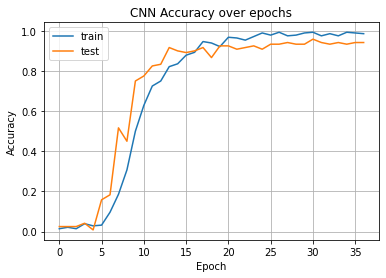

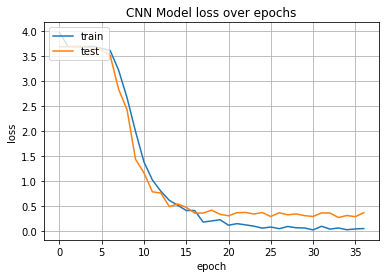

In [66]:
X_train_cnn = X_train.reshape(-1, 64, 64, 1)
X_test_cnn = X_test.reshape(-1, 64, 64, 1)

cnn = Sequential()
cnn.add(Conv2D(filters=20, kernel_size=(5, 5), padding="Same",
               activation="relu", input_shape=(64, 64, 1)))
cnn.add(MaxPool2D(pool_size=(2, 2)))
cnn.add(Dropout(0.25))
cnn.add(Conv2D(filters=50, kernel_size=(6, 6), padding="Same",
               activation="relu"))
cnn.add(MaxPool2D(pool_size=(2, 2)))
cnn.add(Dropout(0.25))
cnn.add(Conv2D(filters=150, kernel_size=(5, 5), padding="Same",
               activation="relu", input_shape=(64, 64, 1)))
cnn.add(Flatten())
cnn.add(Dense(256, activation="relu"))
cnn.add(Dropout(0.5))
cnn.add(Dense(40, activation="softmax"))

optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
cnn.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor="val_sparse_categorical_accuracy",
                                            patience=3,
                                            verbose=1,
                                            factor=0.7,
                                            min_lr=0.00000000001)
early_stopping_monitor = EarlyStopping(patience=2)

epoch = 37
batch_size = 20
history = cnn.fit(
    X_train_cnn,
    y_train,
    epochs=epoch,
    validation_data=(X_test_cnn, y_test),
    verbose=2,
    steps_per_epoch=X_train_cnn.shape[0] // batch_size,
    callbacks=[learning_rate_reduction]
)

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history["sparse_categorical_accuracy"])
plt.plot(history.history["val_sparse_categorical_accuracy"])
plt.title("CNN Accuracy over epochs")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["train", "test"], loc="upper left")
plt.grid()
plt.show()
# summarize history for loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("CNN Model loss over epochs")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.grid()
plt.show()